In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import missingno as msno
from sklearn.compose import ColumnTransformer
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# !pip install missingno

### Data Exploration

In [3]:
df = pd.read_csv("houses.csv").reindex()
df.head()

index                                              title  final_price  \
0      0  1303 - 38 Grenville St, Toronto (C4461599) | Z...       855000   
1      1          2 Cabot Crt, Toronto (W4502992) | Zoocasa       885000   
2      2  1504 - 30 Roehampton Ave, Toronto (C4511330) |...       550000   
3      3  514 - 65 East Liberty St, Toronto (C4515763) |...       665000   
4      4        61 Twelfth St, Toronto (W4519375) | Zoocasa       825513   

   list_price    bedrooms  bathrooms   sqft  parking  \
0      870000  2 + 1 beds          2  850.0        1   
1      898000      3 beds          2    NaN        6   
2      549900      1 beds          1  550.0        0   
3      600000  1 + 1 beds          1  650.0        1   
4      839000      2 beds          2    NaN        1   

                                         description       mls           type  \
0  Luxurious And Spacious Murano Tower. 2+1, 2 Ba...  C4461599      Condo Apt   
1  Fantastic Opportunity To Live Within The Histo...  W4502992  Semi-Detached   
2  Bright Sunfilled Spacious 1 Bdr Unit; Floor To...  C4511330      Condo Apt   
3  Rare Loft-Like Condo In Liberty Village W/ 18'...  C4515763      Condo Apt   
4  Location! Location! Location. Your Cottage In ...  W4519375       Detached   

                                           full_link  \
0  https://www.zoocasa.com/toronto-on-real-estate...   
1  https://www.zoocasa.com/toronto-on-real-estate...   
2  https://www.zoocasa.com/toronto-on-real-estate...   
3  https://www.zoocasa.com/toronto-on-real-estate...   
4  https://www.zoocasa.com/toronto-on-real-estate...   

                                     full_address        lat       long  \
0      38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1          2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
2    30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3   65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
4        61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   

                city_district  mean_district_income  district_code  
0         Bay Street Corridor                 56526             76  
1  Islington-City Centre West                 52787             14  
2         Mount Pleasant West                 57039            104  
3                     Niagara                 70623             82  
4                 New Toronto                 44101             18

In [4]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15234 entries, 0 to 15233
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 15234 non-null  int64  
 1   title                 15234 non-null  object 
 2   final_price           15234 non-null  int64  
 3   list_price            15234 non-null  int64  
 4   bedrooms              15234 non-null  object 
 5   bathrooms             15234 non-null  int64  
 6   sqft                  10713 non-null  float64
 7   parking               15234 non-null  int64  
 8   description           15185 non-null  object 
 9   mls                   15234 non-null  object 
 10  type                  15234 non-null  object 
 11  full_link             15234 non-null  object 
 12  full_address          15234 non-null  object 
 13  lat                   15234 non-null  float64
 14  long                  15234 non-null  float64
 15  city_district      

Index(['index', 'title', 'final_price', 'list_price', 'bedrooms', 'bathrooms',
       'sqft', 'parking', 'description', 'mls', 'type', 'full_link',
       'full_address', 'lat', 'long', 'city_district', 'mean_district_income',
       'district_code'],
      dtype='object')

In [5]:
df.bedrooms

0        2 + 1 beds
1            3 beds
2            1 beds
3        1 + 1 beds
4            2 beds
            ...    
15229        2 beds
15230        5 beds
15231        3 beds
15232        1 beds
15233    2 + 1 beds
Name: bedrooms, Length: 15234, dtype: object

In [6]:
df.drop(['title', 'list_price', 'mls'], axis=1, inplace=True)

### Pre-Processing for Baseline Model

In [7]:
df['bedrooms'] = df['bedrooms'].str.replace(' beds', '')
df['bedrooms'] = df['bedrooms'].str.replace(' +', '')

C:\Users\bevli\AppData\Local\Temp/ipykernel_2468/1930054018.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['bedrooms'] = df['bedrooms'].str.replace(' +', '')


In [8]:
#Splitting bedrooms into bedroom plus den if item contains '+'
bedroom_den = df['bedrooms'].tolist()

bedroom = []
den = [] 

for i in bedroom_den:
    if '+' in i:
        x = i.split('+')
        bedroom.append(x[0])
        den.append(x[1])
    else:
        bedroom.append(i)
        den.append(0)
        

In [9]:
print (len(bedroom), len(den))

15234 15234


In [10]:
#Adding bedroom and den columns to DataFrame

df_1 = pd.concat([pd.Series(bedroom,name='bedroom'),pd.Series(den,name='den')], axis=1).reindex()

# Merge two Dataframes on index of both the dataframes
df = df.merge(df_1, left_index = True, right_index=True)
df.drop(columns = ['bedrooms'], inplace = True, axis = 1)

In [11]:
#Converting bedroom and den object type to int

df[['bedroom','den']] = df[['bedroom','den']].astype('int64')

In [12]:
df.drop('index',inplace = True,axis =1)

### Modeling to Predict missing Square Footage values

In [13]:
df_repl = df.copy(deep = True)

In [14]:
df_repl.drop(['description','full_link','full_address', 'lat', 'long','district_code', 'mean_district_income' ],axis = 1, inplace = True)

final_price       0.000000
bathrooms         0.000000
sqft             29.677038
parking           0.000000
type              0.000000
city_district     0.000000
bedroom           0.000000
den               0.000000
dtype: float64


<AxesSubplot:>

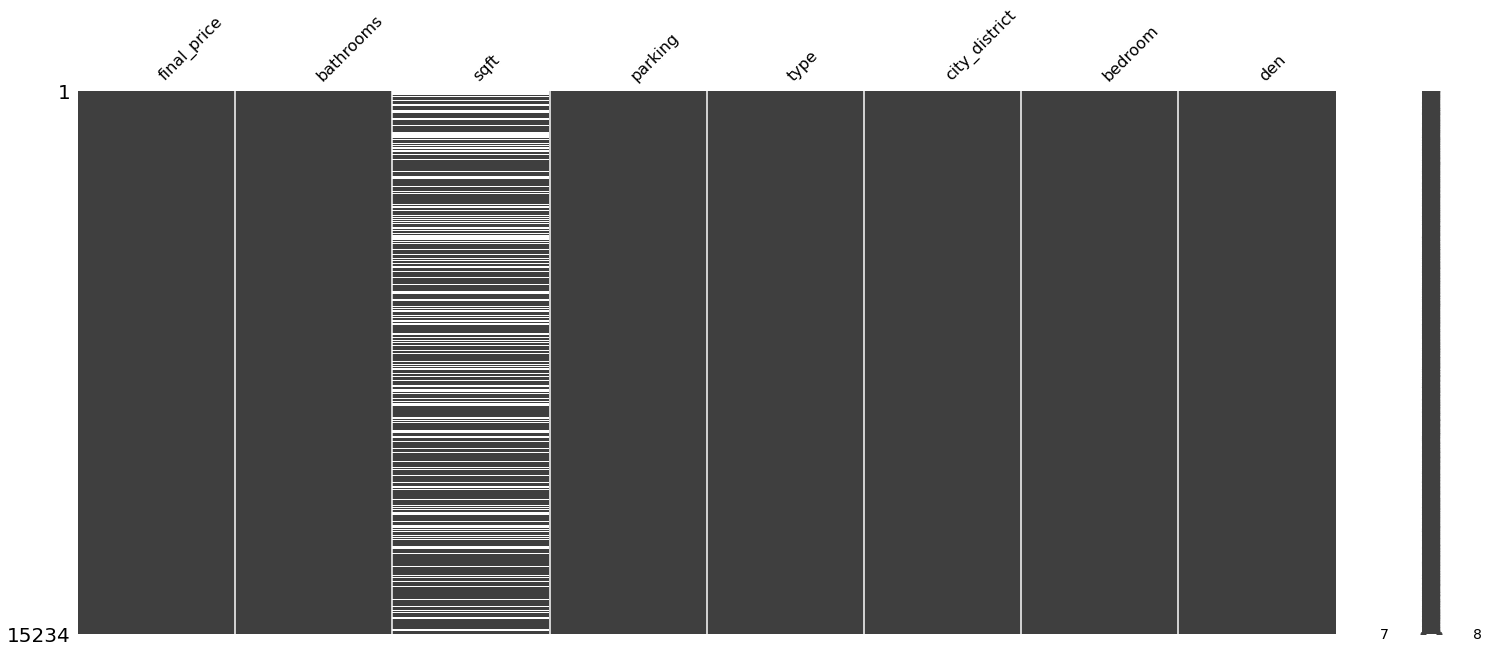

In [15]:
mis_value_percent = 100 * df_repl.isnull().sum() / len(df_repl)
print(mis_value_percent)

msno.matrix(df_repl)

Condo Apt  -  7572
Number of null values -  0


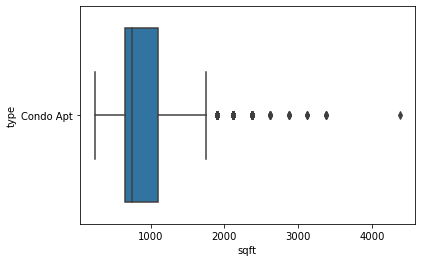

Semi-Detached  -  1435
Number of null values -  1067


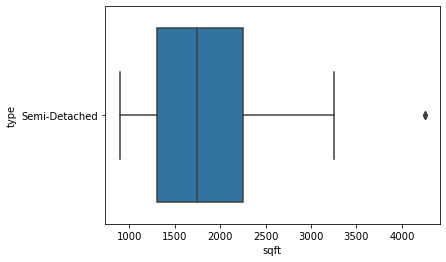

Detached  -  4361
Number of null values -  3144


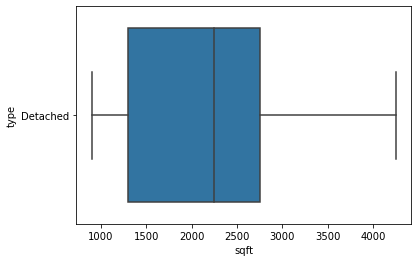

Condo Townhouse  -  1062
Number of null values -  0


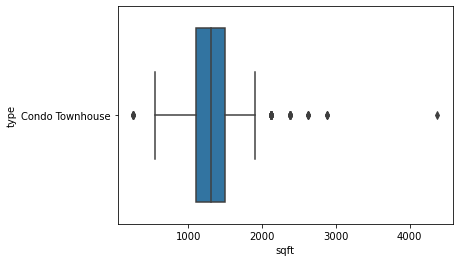

Plex  -  70
Number of null values -  43


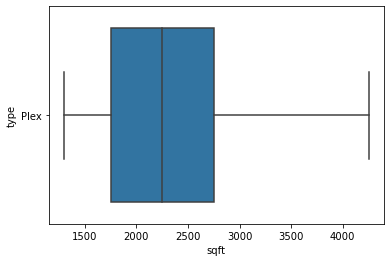

Att/Row/Twnhouse  -  467
Number of null values -  245


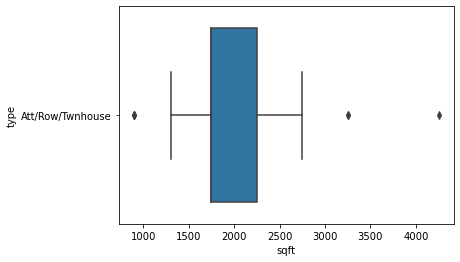

Comm Element Condo  -  181
Number of null values -  0


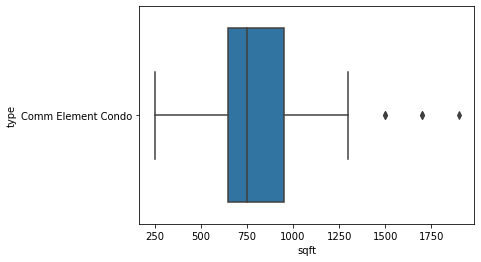

Link  -  27
Number of null values -  16


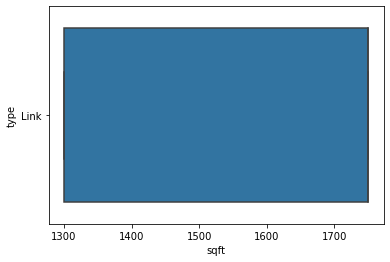

Co-Ownership Apt  -  27
Number of null values -  0


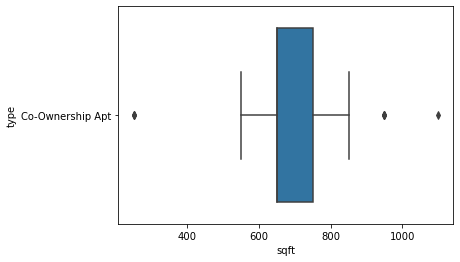

Co-Op Apt  -  24
Number of null values -  0


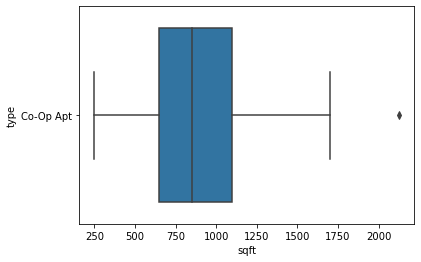

Store W/Apt/Offc  -  8
Number of null values -  6


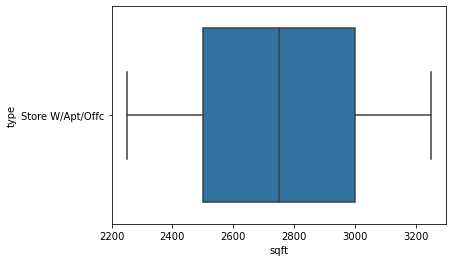

In [16]:
#checking distribution of square footage with respect to various variables

for i in df_repl.type.unique():
    
    print(i," - ", len(df_repl[df_repl['type'] == i]))
    print('Number of null values - ',df_repl[df_repl['type']==i].sqft.isnull().sum())
    sns.boxplot(y = df_repl[df_repl['type'] == i]['type'], x = df_repl.sqft)
    plt.show()


#### *** Since majority of the NaN values are present for the detached and semi detached type of homes, it is not practical to replace NaN values using metric such as mean or median. An XGBRegressor will be used to predict the missing Square Footage Values in order to make a Baseline model and hence, commence with new feature engineering and model optimization.

In [17]:
#Train test split for prediction

test_data = df_repl[df_repl['sqft'].isnull()]
df_repl.dropna(inplace = True)

X_train = df_repl.drop('sqft',axis = 1)
X_test = test_data.drop('sqft',axis = 1)
y_train = df_repl['sqft']

In [18]:
import xgboost
from sklearn.preprocessing import OneHotEncoder

scaler = MinMaxScaler()

In [19]:
X_train.columns

Index(['final_price', 'bathrooms', 'parking', 'type', 'city_district',
       'bedroom', 'den'],
      dtype='object')

In [23]:
#Column Transformer and Creating Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type','city_district']),
    ('sclaer', MinMaxScaler(), ['final_price', 'bathrooms', 'parking', 'bedroom', 'den'])])

from xgboost import XGBRegressor

pipeline = Pipeline(steps = [('features',preprocessor),
                            ('xgbregressor',XGBRegressor())])

In [24]:
#Fit the Pipeline and predict square foot values

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [25]:
#preparing X_test and X_train for concatenation
X_test['sqft'] = y_pred
X_train['sqft'] = y_train

In [26]:
df_merged = pd.concat([X_train, X_test], ignore_index=False, sort=False)
df_merged

final_price  bathrooms  parking              type  \
0           855000          2        1         Condo Apt   
2           550000          1        0         Condo Apt   
3           665000          1        1         Condo Apt   
5           368000          1        1         Condo Apt   
6          2700000          5        2          Detached   
...            ...        ...      ...               ...   
15218      1595000          3        4          Detached   
15223      1222500          3        6          Detached   
15226      1050000          4        4          Detached   
15231       681000          3        1  Att/Row/Twnhouse   
15233       530000          2        4          Detached   

                city_district  bedroom  den         sqft  
0         Bay Street Corridor        2    1   850.000000  
2         Mount Pleasant West        1    0   550.000000  
3                     Niagara        1    1   650.000000  
5                 New Toronto        0    0   250.000000  
6         Lawrence Park South        4    0  2750.000000  
...                       ...      ...  ...          ...  
15218      Princess-Rosethorn        3    1  2399.219727  
15223          Bathurst Manor        3    1  1794.945190  
15226              L'Amoreaux        5    2  2892.250244  
15231  Centennial Scarborough        3    0  1695.414795  
15233   Birchcliffe-Cliffside        2    1  1086.917725  

[15234 rows x 8 columns]

In [27]:
## Merging newly predicted square footage values to orginal dataframe

# merge
dfx = pd.merge(df, df_merged[['sqft']], left_index = True,
    right_index = True)

# coalesce sqft column to get first non NA value
dfx['sqft'] = dfx['sqft_x'].combine_first(dfx['sqft_y']).astype('int64')

# remove the cols
dfx = dfx.drop(['sqft_x', 'sqft_y'], 1)

C:\Users\bevli\AppData\Local\Temp/ipykernel_2468/2869888798.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfx = dfx.drop(['sqft_x', 'sqft_y'], 1)


In [28]:
dfx

final_price  bathrooms  parking  \
0           855000          2        1   
1           885000          2        6   
2           550000          1        0   
3           665000          1        1   
4           825513          2        1   
...            ...        ...      ...   
15229       785000          2        1   
15230      1025000          5        2   
15231       681000          3        1   
15232       590000          1        0   
15233       530000          2        4   

                                             description              type  \
0      Luxurious And Spacious Murano Tower. 2+1, 2 Ba...         Condo Apt   
1      Fantastic Opportunity To Live Within The Histo...     Semi-Detached   
2      Bright Sunfilled Spacious 1 Bdr Unit; Floor To...         Condo Apt   
3      Rare Loft-Like Condo In Liberty Village W/ 18'...         Condo Apt   
4      Location! Location! Location. Your Cottage In ...          Detached   
...                                                  ...               ...   
15229  Tableau Condo - Right In The Middle Of The Ent...         Condo Apt   
15230  New Years Special. Brand New House. Beautiful ...          Detached   
15231  Absolutely Beautiful **Freehold ** **End Unit*...  Att/Row/Twnhouse   
15232  One Year New Luxury Condo Built By Menkes. Hig...         Condo Apt   
15233  Great Builder Lot In Birchcliff Village. Can B...          Detached   

                                               full_link  \
0      https://www.zoocasa.com/toronto-on-real-estate...   
1      https://www.zoocasa.com/toronto-on-real-estate...   
2      https://www.zoocasa.com/toronto-on-real-estate...   
3      https://www.zoocasa.com/toronto-on-real-estate...   
4      https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15229  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15231  https://www.zoocasa.com/toronto-on-real-estate...   
15232  https://www.zoocasa.com/toronto-on-real-estate...   
15233  https://www.zoocasa.com/toronto-on-real-estate...   

                                         full_address        lat       long  \
0          38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1              2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
2        30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3       65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
4            61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   
...                                               ...        ...        ...   
15229         125 Peter St, Toronto , Ontario, Canada  43.648317 -79.393065   
15230      179 Raleigh Ave, Toronto , Ontario, Canada  43.706338 -79.262789   
15231    68 Stagecoach Cir, Toronto , Ontario, Canada  43.788258 -79.160342   
15232        365 Church St, Toronto , Ontario, Canada  43.660846 -79.378756   
15233        43 Kalmar Ave, Toronto , Ontario, Canada  43.691296 -79.268417   

                           city_district  mean_district_income  district_code  \
0                    Bay Street Corridor                 56526             76   
1             Islington-City Centre West                 52787             14   
2                    Mount Pleasant West                 57039            104   
3                                Niagara                 70623             82   
4                            New Toronto                 44101             18   
...                                  ...                   ...            ...   
15229  Waterfront Communities-The Island                 70600             77   
15230                Clairlea-Birchmount                 36232            120   
15231             Centennial Scarborough                 54045            133   
15232              Church-Yonge Corridor                 53583             75   
1523

In [29]:
dfx.columns

Index(['final_price', 'bathrooms', 'parking', 'description', 'type',
       'full_link', 'full_address', 'lat', 'long', 'city_district',
       'mean_district_income', 'district_code', 'bedroom', 'den', 'sqft'],
      dtype='object')

### Baseline model

In [37]:
X = dfx[['bathrooms', 'parking', 'type',
       'city_district','mean_district_income','bedroom', 'den', 'sqft']]

y = dfx[['final_price']]

In [38]:
#train test split

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state = 42)

In [40]:
#Column Transformer and Creating Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type','city_district']),
    ('sclaer', MinMaxScaler(), ['bathrooms', 'parking', 'bedroom', 'den',
                               'sqft','mean_district_income',])])

from xgboost import XGBRegressor

pipeline = Pipeline(steps = [('features',preprocessor),
                            ('xgbregressor',XGBRegressor(objective='reg:squarederror'))])

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics
from sklearn.metrics import mean_squared_error

In [64]:
#parameters for gridsearch

base_model = LinearRegression()
ridge = Ridge()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xgb = XGBRegressor()

models = [ridge, rfr, gbr]

params = [{
           'models':[ridge],
           'models__alpha':[0.001,0.01,0.1,1,10]
          },
          {
        'models':[rfr],
        "models__n_estimators":[100, 150, 200],
        "models__max_depth":[5,7, 10]
        
    },
    {
        'models':[gbr],
        "models__learning_rate":[0.1, 0.2, 0.3],
        "models__n_estimators":[100, 150, 200],
        "models__max_depth":[5,7, 10]
    },
    {
        'models':[xgb],
        'models__learning_rate': [0.01, 0.1, 0.4, 0.8],
        'models__colsample_bytree': [0.6, 0.8, 1.0],
        'models__max_depth': [3, 5, 8, 12],
        'models__reg_alpha':[0,0.1,0.4,1.6,12.8, 51.2],
        'models__n_estimators':[50,100,200],
    }]

final_pipeline = Pipeline(steps = [('features',preprocessor),('models',base_model)])


In [65]:
#fitting gridsearchCV

gridsearch = GridSearchCV(final_pipeline, params,scoring = ['neg_mean_squared_error', 'r2'], verbose=5, refit = 'r2').fit(X_train, y_train)


Fitting 5 folds for each of 905 candidates, totalling 4525 fits
[CV 1/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-73941909927.120) r2: (test=0.791) total time=   0.2s
[CV 2/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-65239343959.414) r2: (test=0.810) total time=   0.0s
[CV 3/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-60237387467.207) r2: (test=0.819) total time=   0.0s
[CV 4/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-103997577939.591) r2: (test=0.740) total time=   0.0s
[CV 5/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-87088527461.451) r2: (test=0.794) total time=   0.0s
[CV 1/5] END models=Ridge(), models__alpha=0.01; neg_mean_squared_error: (test=-73940441308.832) r2: (test=0.791) total time=   0.0s
[CV 2/5] END models=Ridge(), models__alpha=0.01; neg_mean_squared_error: (test=-65238307208.340) r2: (test=0.810) total time=   0.0s

C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-70025654450.498) r2: (test=0.802) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-66532163440.499) r2: (test=0.806) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-57689459447.217) r2: (test=0.827) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-89816996401.463) r2: (test=0.776) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-75084239567.157) r2: (test=0.822) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-68937466532.267) r2: (test=0.806) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-68322587211.602) r2: (test=0.801) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-57055709779.200) r2: (test=0.828) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-91301622471.358) r2: (test=0.772) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-74068710057.758) r2: (test=0.825) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-69810789161.073) r2: (test=0.803) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-67331322194.962) r2: (test=0.803) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-57728209662.313) r2: (test=0.826) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-89694087905.935) r2: (test=0.776) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-75568780956.000) r2: (test=0.821) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-58014921198.050) r2: (test=0.836) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-62005151277.397) r2: (test=0.819) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-50932947095.342) r2: (test=0.847) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-81115104384.735) r2: (test=0.797) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-72525166947.039) r2: (test=0.828) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-57921054497.086) r2: (test=0.837) total time=   3.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-60335931380.280) r2: (test=0.824) total time=   3.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-52410476820.242) r2: (test=0.842) total time=   3.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-81531563668.950) r2: (test=0.796) total time=   3.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-72649561254.205) r2: (test=0.828) total time=   3.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-57439540623.592) r2: (test=0.838) total time=   4.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-62144858889.441) r2: (test=0.819) total time=   4.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-50225581371.161) r2: (test=0.849) total time=   4.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-79840896778.761) r2: (test=0.801) total time=   4.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-73697176960.604) r2: (test=0.825) total time=   4.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-51217236239.224) r2: (test=0.856) total time=   4.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-54318035915.462) r2: (test=0.841) total time=   4.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-46957582882.480) r2: (test=0.859) total time=   4.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-74329384288.888) r2: (test=0.814) total time=   5.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-69476717139.487) r2: (test=0.835) total time=   5.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-49712206109.009) r2: (test=0.860) total time=   7.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-54500359671.874) r2: (test=0.841) total time=   7.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-44520712863.110) r2: (test=0.866) total time=   7.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-73455913258.576) r2: (test=0.817) total time=   7.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-67401375741.968) r2: (test=0.840) total time=   7.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-49837319565.145) r2: (test=0.859) total time=  10.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-54331135520.172) r2: (test=0.841) total time=  10.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-45395162236.231) r2: (test=0.863) total time=  10.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-74992433848.805) r2: (test=0.813) total time=  10.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-69302088196.267) r2: (test=0.836) total time=  10.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-47585873955.832) r2: (test=0.866) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-59790645969.663) r2: (test=0.825) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-44424434305.975) r2: (test=0.866) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-57814520316.527) r2: (test=0.856) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-66460715848.260) r2: (test=0.843) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-45390759262.231) r2: (test=0.872) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-58302298574.991) r2: (test=0.830) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-46706770036.972) r2: (test=0.860) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-57091957032.828) r2: (test=0.857) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-62719076428.748) r2: (test=0.851) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-44086752620.393) r2: (test=0.876) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-57702900623.563) r2: (test=0.832) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-45284616735.573) r2: (test=0.864) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-56171297202.956) r2: (test=0.860) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-61017817027.469) r2: (test=0.855) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-44778141659.909) r2: (test=0.874) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-53617687796.883) r2: (test=0.843) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-42879699563.110) r2: (test=0.871) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-61643911391.279) r2: (test=0.846) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-72139261041.179) r2: (test=0.829) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-44341782448.660) r2: (test=0.875) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-52670275223.623) r2: (test=0.846) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-42397495059.032) r2: (test=0.873) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-61403221577.734) r2: (test=0.847) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-71852799344.721) r2: (test=0.830) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-43869919669.118) r2: (test=0.876) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-53051475816.850) r2: (test=0.845) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-42462286644.353) r2: (test=0.872) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-60861598315.571) r2: (test=0.848) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-71816210682.767) r2: (test=0.830) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-47225000754.936) r2: (test=0.867) total time=   3.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-56705297826.254) r2: (test=0.834) total time=   3.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-45030609720.952) r2: (test=0.865) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-81740847174.413) r2: (test=0.796) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-108546354282.916) r2: (test=0.743) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-46305692775.337) r2: (test=0.869) total time=   3.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-57019981647.467) r2: (test=0.834) total time=   3.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-43768695908.021) r2: (test=0.868) total time=   3.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-81990647485.808) r2: (test=0.795) total time=   3.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-110042962327.994) r2: (test=0.739) total time=   3.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-47227983852.719) r2: (test=0.867) total time=   4.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-57080431817.488) r2: (test=0.833) total time=   4.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-44949567698.730) r2: (test=0.865) total time=   4.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-82281581203.457) r2: (test=0.795) total time=   4.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-111111615457.563) r2: (test=0.737) total time=   4.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-44212464527.291) r2: (test=0.875) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-53677686191.530) r2: (test=0.843) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-38765863556.817) r2: (test=0.883) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-60024805585.569) r2: (test=0.850) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-61968377209.312) r2: (test=0.853) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-43326112713.593) r2: (test=0.878) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-53055743640.837) r2: (test=0.845) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-38134121362.915) r2: (test=0.885) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-58205258580.427) r2: (test=0.855) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-59748513619.361) r2: (test=0.858) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-42592749753.084) r2: (test=0.880) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-54191816440.267) r2: (test=0.842) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-41440326944.506) r2: (test=0.875) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-58855724627.181) r2: (test=0.853) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-59785920616.004) r2: (test=0.858) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-42582755344.784) r2: (test=0.880) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-53486602827.224) r2: (test=0.844) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-42061724938.119) r2: (test=0.874) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-65275622644.356) r2: (test=0.837) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-65129943023.596) r2: (test=0.846) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-42923112582.415) r2: (test=0.879) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-52233718166.170) r2: (test=0.848) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-42302812748.853) r2: (test=0.873) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-64841930134.909) r2: (test=0.838) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-67763994725.554) r2: (test=0.839) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-43679958129.989) r2: (test=0.877) total time=   2.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-53034860513.003) r2: (test=0.845) total time=   2.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-43215837567.459) r2: (test=0.870) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-64431553674.904) r2: (test=0.839) total time=   2.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-69678708840.541) r2: (test=0.835) total time=   2.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-49364028776.319) r2: (test=0.861) total time=   2.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-54432979036.725) r2: (test=0.841) total time=   2.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-38194781492.912) r2: (test=0.885) total time=   2.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-81245845509.668) r2: (test=0.797) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-100403336767.791) r2: (test=0.762) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-48044833183.709) r2: (test=0.864) total time=   3.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-54888259592.088) r2: (test=0.840) total time=   3.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-44246413430.096) r2: (test=0.867) total time=   3.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-82239029631.990) r2: (test=0.795) total time=   3.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-98888037036.700) r2: (test=0.766) total time=   3.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-48908894484.700) r2: (test=0.862) total time=   4.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-59244346470.913) r2: (test=0.827) total time=   4.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-39823261230.087) r2: (test=0.880) total time=   4.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-82674244774.469) r2: (test=0.794) total time=   4.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-99345168788.369) r2: (test=0.765) total time=   4.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-42767424917.735) r2: (test=0.879) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-54585633292.057) r2: (test=0.841) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-42368128862.218) r2: (test=0.873) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-57910086617.530) r2: (test=0.855) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-63663893874.367) r2: (test=0.849) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-41505722728.457) r2: (test=0.883) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-52765067904.872) r2: (test=0.846) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-43615277905.366) r2: (test=0.869) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-58191999206.607) r2: (test=0.855) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-63754721272.709) r2: (test=0.849) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-41910798739.257) r2: (test=0.882) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-53748472912.562) r2: (test=0.843) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-44157675344.834) r2: (test=0.867) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-57812604014.694) r2: (test=0.856) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-65013576093.571) r2: (test=0.846) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-42957790838.566) r2: (test=0.879) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-56137845163.284) r2: (test=0.836) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-46599670986.855) r2: (test=0.860) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-59704001574.264) r2: (test=0.851) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-74613780761.041) r2: (test=0.823) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-43489623094.493) r2: (test=0.877) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-57917734849.094) r2: (test=0.831) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-47952012773.660) r2: (test=0.856) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-61021267309.290) r2: (test=0.848) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-70804584833.043) r2: (test=0.832) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-44094818629.242) r2: (test=0.876) total time=   2.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-55545050209.919) r2: (test=0.838) total time=   2.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-48620115880.840) r2: (test=0.854) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-60934864634.743) r2: (test=0.848) total time=   2.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-74483331608.446) r2: (test=0.824) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-49651647736.036) r2: (test=0.860) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-54838010603.366) r2: (test=0.840) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-44262442189.193) r2: (test=0.867) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-89048246650.477) r2: (test=0.778) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-110582545867.731) r2: (test=0.738) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-49060516575.558) r2: (test=0.862) total time=   3.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-56348169202.812) r2: (test=0.835) total time=   3.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-48936870385.095) r2: (test=0.853) total time=   3.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-88751705523.024) r2: (test=0.778) total time=   3.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-109464076259.124) r2: (test=0.741) total time=   3.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-50059882174.029) r2: (test=0.859) total time=   4.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-64046255282.313) r2: (test=0.813) total time=   4.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-41692579647.328) r2: (test=0.875) total time=   4.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-90081536744.265) r2: (test=0.775) total time=   4.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-110796281517.365) r2: (test=0.738) total time=   5.2s
[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__le

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-485006420331.769) r2: (test=-0.368) total time=   0.2s
[CV 2/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-485006427817.717) r2: (test=-0.368) total time=   0.0s
[CV 2/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-242779550807.788) r2: (test=0.315) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-270950486238.477) r2: (test=0.358) total time=   0.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-270884815583.570) r2: (test=0.324) total time=   0.1s
[CV 5/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-270884855942.620) r2: (test=0.324) total time=   0.1s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-81690371484.074) r2: (test=0.754) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-95849171143.833) r2: (test=0.720) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-103324310093.267) r2: (test=0.709) total time=   0.3s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-526260283816.211) r2: (test=-0.247) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-526260284835.002) r2: (test=-0.247) total time=   0.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-526243858865.210) r2: (test=-0.247) total time=   0.0s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-256360118437.928) r2: (test=0.360) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-201376137061.491) r2: (test=0.394) total time=   0.1s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-214800438792.122) r2: (test=0.373) total time=   0.2s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-85982090875.403) r2: (test=0.757) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-101761082191.896) r2: (test=0.759) total time=   0.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-107921272318.038) r2: (test=0.731) total time=   0.3s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-69014540115.284) r2: (test=0.792) total time=   0.4s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-459832796227.375) r2: (test=-0.342) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-465546462196.331) r2: (test=-0.313) total time=   0.1s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-522301748432.236) r2: (test=-0.237) total time=   0.1s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-253901605678.697) r2: (test=0.366) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-195906533315.855) r2: (test=0.411) total time=   0.4s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-208285372514.394) r2: (test=0.392) total time=   0.3s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-76755558054.528) r2: (test=0.783) total time=   0.8s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-94893634194.731) r2: (test=0.775) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-102542499238.339) r2: (test=0.744) total time=   0.7s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-61631061926.275) r2: (test=0.815) total time=   0.7s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-457788402182.084) r2: (test=-0.336) total time=   0.2s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-463434316877.375) r2: (test=-0.307) total time=   0.2s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-520152910972.845) r2: (test=-0.232) total time=   0.2s
[CV 1/5] END models=XGBRegressor(b

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-251687155917.587) r2: (test=0.372) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-193472627565.001) r2: (test=0.418) total time=   0.4s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-206067875081.258) r2: (test=0.398) total time=   0.4s
[CV 3/5] END models=XGBRegressor(b

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-73909618523.342) r2: (test=0.791) total time=   1.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-91954957728.048) r2: (test=0.782) total time=   1.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-99199379555.907) r2: (test=0.752) total time=   1.3s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58714364764.445) r2: (test=0.823) total time=   1.1s
[CV 4/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-52722130812.732) r2: (test=0.841) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-52722131120.020) r2: (test=0.841) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-66409688617.317) r2: (test=0.806) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-61943639378.174) r2: (test=0.819) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-61943635850.288) r2: (test=0.819) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-61943611390.191) r2: (test=0.819) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-53210156316.202) r2: (test=0.850) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-65092498673.725) r2: (test=0.846) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-58780627731.797) r2: (test=0.853) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-60110109658.814) r2: (test=0.850) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-60110111797.709) r2: (test=0.850) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-60110154260.154) r2: (test=0.850) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-55036496746.904) r2: (test=0.863) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-55036496511.983) r2: (test=0.863) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-41123148381.122) r2: (test=0.876) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-50062403616.995) r2: (test=0.854) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-45839574844.978) r2: (test=0.871) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-55104591464.580) r2: (test=0.869) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51613926749.028) r2: (test=0.871) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-58473651726.418) r2: (test=0.854) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-37041771041.331) r2: (test=0.889) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-52106518787.080) r2: (test=0.848) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-42316505496.008) r2: (test=0.881) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-56444490944.893) r2: (test=0.866) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-54226073341.457) r2: (test=0.865) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-35523650902.776) r2: (test=0.893) total time=   0.6s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-52195542672.534) r2: (test=0.848) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-41633287459.592) r2: (test=0.883) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-56208130150.255) r2: (test=0.867) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65041138878.216) r2: (test=0.838) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-36139742078.951) r2: (test=0.891) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-52104261367.979) r2: (test=0.848) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44028034870.188) r2: (test=0.876) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-58283302123.470) r2: (test=0.862) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-61718045504.254) r2: (test=0.846) total time=   0.4s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-37369166995.764) r2: (test=0.888) total time=   1.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-53974444429.883) r2: (test=0.842) total time=   0.9s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-45255771329.493) r2: (test=0.872) total time=   0.9s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58379364194.636) r2: (test=0.862) total time=   0.8s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-60685693042.151) r2: (test=0.848) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-51245375366.311) r2: (test=0.846) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51245326654.639) r2: (test=0.846) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-47863696589.637) r2: (test=0.856) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-47863698293.152) r2: (test=0.856) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47863654132.606) r2: (test=0.856) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-57090860616.956) r2: (test=0.833) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-41893976751.129) r2: (test=0.882) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-64039385718.728) r2: (test=0.848) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-53839056501.352) r2: (test=0.866) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-53839055239.872) r2: (test=0.866) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-53839076422.930) r2: (test=0.866) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-37386503976.121) r2: (test=0.888) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-51933410397.612) r2: (test=0.848) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-47404506906.193) r2: (test=0.866) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51614309316.021) r2: (test=0.878) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-51541165458.463) r2: (test=0.871) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-37476233351.215) r2: (test=0.887) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51322801961.222) r2: (test=0.850) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-50155963897.873) r2: (test=0.854) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-50155963491.465) r2: (test=0.854) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-42628042338.470) r2: (test=0.880) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-58791661033.081) r2: (test=0.861) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-55683178083.710) r2: (test=0.861) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-41778055070.312) r2: (test=0.874) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-52137117593.430) r2: (test=0.848) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-45039198386.258) r2: (test=0.873) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-59511978618.841) r2: (test=0.859) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-57616293234.288) r2: (test=0.856) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-46464949631.845) r2: (test=0.860) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-55755710485.368) r2: (test=0.837) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-49668165656.060) r2: (test=0.860) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-62247163163.149) r2: (test=0.853) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-61046130367.929) r2: (test=0.848) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-46448657906.635) r2: (test=0.860) total time=   0.4s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-57115258825.767) r2: (test=0.833) total time=   0.9s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-51831555925.567) r2: (test=0.854) total time=   1.0s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-62891171327.396) r2: (test=0.851) total time=   0.8s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-62531530288.042) r2: (test=0.844) total time=   1.0s
[CV 5/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-58868851146.739) r2: (test=0.853) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-53532794186.847) r2: (test=0.839) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-59759874473.624) r2: (test=0.826) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44372909146.643) r2: (test=0.875) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44372911936.705) r2: (test=0.875) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-44372743976.966) r2: (test=0.875) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-72802371295.641) r2: (test=0.828) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-57519024523.634) r2: (test=0.856) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-44788743991.731) r2: (test=0.865) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-59700778257.980) r2: (test=0.826) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59700774880.604) r2: (test=0.826) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-59700704655.704) r2: (test=0.826) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-50409951370.803) r2: (test=0.858) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-59870851717.830) r2: (test=0.858) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-58487305776.459) r2: (test=0.854) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-49067358053.242) r2: (test=0.852) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65804859009.672) r2: (test=0.808) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-53842803412.482) r2: (test=0.848) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-61621052274.909) r2: (test=0.854) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-70128225505.501) r2: (test=0.834) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_sco

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-70128225176.853) r2: (test=0.834) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-70128055298.007) r2: (test=0.834) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-66400197499.426) r2: (test=0.834) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-47250932346.130) r2: (test=0.858) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-73796926141.419) r2: (test=0.785) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-62601742510.741) r2: (test=0.823) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71968155740.416) r2: (test=0.830) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-68455883925.520) r2: (test=0.829) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47849784205.005) r2: (test=0.856) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71581327873.710) r2: (test=0.791) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-62966099165.668) r2: (test=0.822) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-85537146795.814) r2: (test=0.797) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-75850519018.539) r2: (test=0.811) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-60281876664.319) r2: (test=0.819) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-72160308455.514) r2: (test=0.789) total time=   0.5s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-64647235557.509) r2: (test=0.818) total time=   1.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-86749869096.082) r2: (test=0.795) total time=   1.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-76178448518.165) r2: (test=0.810) total time=   1.0s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-61183822706.657) r2: (test=0.816) total time=   0.9s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-471231889901.738) r2: (test=-0.376) total time=   0.0s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-479316291931.238) r2: (test=-0.352) total time=   0.0s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-531136505443.216) r2: (test=-0.258) total time=   0.0s
[CV 1/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-263543717651.458) r2: (test=0.376) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-263543717651.458) r2: (test=0.376) total time=   0.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-263543725842.502) r2: (test=0.376) total time=   0.1s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-116788865632.204) r2: (test=0.708) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-79567418671.745) r2: (test=0.761) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-93340979621.277) r2: (test=0.727) total time=   0.2s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-456526143470.096) r2: (test=-0.333) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-456462789698.412) r2: (test=-0.333) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-456462814198.485) r2: (test=-0.333) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-217737081476.431) r2: (test=0.386) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-246555170188.117) r2: (test=0.416) total time=   0.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-247976670631.059) r2: (test=0.381) total time=   0.2s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-196006818002.216) r2: (test=0.411) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-79786176480.064) r2: (test=0.767) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-83831937013.511) r2: (test=0.764) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-98243563332.745) r2: (test=0.767) total time=   0.4s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-513609849565.273) r2: (test=-0.217) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-506063937233.755) r2: (test=-0.263) total time=   0.1s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-438388368330.641) r2: (test=-0.318) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-203046299112.187) r2: (test=0.407) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-210897701507.176) r2: (test=0.405) total time=   0.3s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-242046305325.748) r2: (test=0.427) total time=   0.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-247505438239.473) r2: (test=0.382) total time=   0.3s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-59059345533.206) r2: (test=0.822) total time=   0.7s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-71627294293.429) r2: (test=0.791) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-74240430947.646) r2: (test=0.791) total time=   0.6s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-512530105493.776) r2: (test=-0.214) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-505416751217.332) r2: (test=-0.262) total time=   0.2s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-436910778497.813) r2: (test=-0.314) total time=   0.2s
[CV 4/5] END models=XGBRegressor(b

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-200788081913.444) r2: (test=0.414) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-209196174265.615) r2: (test=0.410) total time=   0.5s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-238753693026.193) r2: (test=0.434) total time=   0.5s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-246966254394.664) r2: (test=0.383) total time=   0.6s
[CV 5/5] END models=XGBRegressor(b

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-57370165382.262) r2: (test=0.827) total time=   1.3s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-69058215440.248) r2: (test=0.798) total time=   1.2s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-72233226849.020) r2: (test=0.796) total time=   1.1s
[CV 2/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-63689471419.931) r2: (test=0.820) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-75001675014.654) r2: (test=0.822) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-75001668389.472) r2: (test=0.822) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-66603712439.565) r2: (test=0.834) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-66603712791.372) r2: (test=0.834) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-66603749807.667) r2: (test=0.834) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-47106037029.084) r2: (test=0.858) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-57614518898.216) r2: (test=0.832) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52711692458.057) r2: (test=0.851) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-64186963802.620) r2: (test=0.848) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-62308780153.327) r2: (test=0.852) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-62308785348.812) r2: (test=0.852) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-62308785688.522) r2: (test=0.852) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-60828988685.960) r2: (test=0.848) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-43981347280.154) r2: (test=0.868) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-56426447669.887) r2: (test=0.835) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44394931848.793) r2: (test=0.875) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-57541209451.999) r2: (test=0.864) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-57228607870.561) r2: (test=0.857) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-42307054948.704) r2: (test=0.873) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-55312238444.349) r2: (test=0.839) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-42909745127.614) r2: (test=0.879) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-59123309132.409) r2: (test=0.860) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-58931816167.616) r2: (test=0.853) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-41847499426.635) r2: (test=0.874) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-54766636559.619) r2: (test=0.840) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-39865785486.827) r2: (test=0.888) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-57208429238.540) r2: (test=0.864) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-57968151790.357) r2: (test=0.855) total time=   0.6s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-42203114534.621) r2: (test=0.873) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-54269931809.445) r2: (test=0.842) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-45352322238.662) r2: (test=0.872) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-60333160814.761) r2: (test=0.857) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-60683554550.713) r2: (test=0.848) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44051947038.009) r2: (test=0.868) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-55962540328.519) r2: (test=0.837) total time=   0.5s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-45408324278.576) r2: (test=0.872) total time=   1.0s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-60993099017.564) r2: (test=0.856) total time=   1.0s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-60752877052.924) r2: (test=0.848) total time=   1.0s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-46358870550.732) r2: (test=0.861) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-57696565685.205) r2: (test=0.832) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-46358871886.986) r2: (test=0.861) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-43607446183.958) r2: (test=0.869) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-43607443815.621) r2: (test=0.869) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-43607445282.271) r2: (test=0.869) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-56890940498.107) r2: (test=0.834) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-44711259980.601) r2: (test=0.874) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-58332974602.165) r2: (test=0.862) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-54416228025.977) r2: (test=0.864) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44800992207.717) r2: (test=0.865) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44800984072.454) r2: (test=0.865) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-44800844697.282) r2: (test=0.865) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-55172256216.061) r2: (test=0.839) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-40581648849.253) r2: (test=0.886) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-68398872220.306) r2: (test=0.838) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-59931025161.225) r2: (test=0.850) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-43772250670.117) r2: (test=0.868) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56129784397.521) r2: (test=0.836) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-44242539336.713) r2: (test=0.875) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sco

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-73425308354.729) r2: (test=0.826) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-73425298907.578) r2: (test=0.826) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-73719365652.494) r2: (test=0.825) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-61094967348.626) r2: (test=0.847) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44662237356.186) r2: (test=0.866) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-57963323455.338) r2: (test=0.831) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-46429727412.766) r2: (test=0.869) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-76256267619.144) r2: (test=0.819) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-62241659891.492) r2: (test=0.845) total time=   0.6s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-47530545124.507) r2: (test=0.857) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-60359788742.192) r2: (test=0.824) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-47424481514.703) r2: (test=0.866) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-70515096120.921) r2: (test=0.833) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-75856684499.229) r2: (test=0.811) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-47907899812.175) r2: (test=0.856) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-61272772543.678) r2: (test=0.821) total time=   0.4s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-49615395620.728) r2: (test=0.860) total time=   0.9s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-74489147060.318) r2: (test=0.824) total time=   0.9s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-77369020675.715) r2: (test=0.807) total time=   0.9s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-52341492711.782) r2: (test=0.843) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-56965757914.061) r2: (test=0.858) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52341454530.686) r2: (test=0.843) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-48940906749.089) r2: (test=0.853) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-48940911831.475) r2: (test=0.853) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-48940874975.212) r2: (test=0.853) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-55562949274.685) r2: (test=0.838) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-48144545996.647) r2: (test=0.864) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-71396939736.130) r2: (test=0.831) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-56282681422.172) r2: (test=0.859) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-49339970005.908) r2: (test=0.852) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-49339965435.329) r2: (test=0.852) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-49341913238.443) r2: (test=0.852) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65197698076.939) r2: (test=0.810) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-54806931637.643) r2: (test=0.845) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-68601547538.071) r2: (test=0.837) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-91302500378.535) r2: (test=0.772) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-52833585272.114) r2: (test=0.841) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-66909062198.935) r2: (test=0.805) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-61282237937.022) r2: (test=0.821) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-61282225950.148) r2: (test=0.821) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-45207592145.723) r2: (test=0.872) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-69295763205.275) r2: (test=0.836) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-75847994920.916) r2: (test=0.811) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-49548153640.096) r2: (test=0.851) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-62769257507.671) r2: (test=0.817) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-50809925553.728) r2: (test=0.857) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-72095938849.496) r2: (test=0.829) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-77461752360.344) r2: (test=0.807) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-52377082516.022) r2: (test=0.843) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-58996534019.724) r2: (test=0.828) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52822667951.080) r2: (test=0.851) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-69417248858.826) r2: (test=0.836) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71415593922.127) r2: (test=0.822) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-52643304167.711) r2: (test=0.842) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-59074868458.311) r2: (test=0.828) total time=   0.4s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-54792470683.882) r2: (test=0.845) total time=   0.9s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-71733343609.315) r2: (test=0.830) total time=   0.9s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-71987200979.033) r2: (test=0.820) total time=   1.0s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-449518186452.467) r2: (test=-0.352) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-467670551957.972) r2: (test=-0.365) total time=   0.0s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-467670555790.351) r2: (test=-0.365) total time=   0.0s
[CV 3/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-224108902290.310) r2: (test=0.346) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-224108902290.310) r2: (test=0.346) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-224108904853.396) r2: (test=0.346) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-99553689341.017) r2: (test=0.719) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-108442684441.108) r2: (test=0.743) total time=   0.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-116812157934.854) r2: (test=0.708) total time=   0.2s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-79966212849.052) r2: (test=0.760) total time=   0.2s
[CV 4/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-437943851366.840) r2: (test=-0.317) total time=   0.1s
[CV 4/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-437943857668.343) r2: (test=-0.317) total time=   0.0s
[CV 4/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-437943964322.041) r2: (test=-0.317) total time=   0.0s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-206229588981.235) r2: (test=0.398) total time=   0.2s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-216817420790.593) r2: (test=0.388) total time=   0.2s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-240542606436.136) r2: (test=0.430) total time=   0.2s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-100646165022.983) r2: (test=0.749) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-67626104386.314) r2: (test=0.797) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-81532056536.220) r2: (test=0.762) total time=   0.5s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-458751727824.995) r2: (test=-0.294) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-509635798660.142) r2: (test=-0.207) total time=   0.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-503156558280.261) r2: (test=-0.256) total time=   0.1s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-436695956138.549) r2: (test=-0.313) total time=   0.1s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-199998340776.130) r2: (test=0.416) total time=   0.3s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-211885840310.756) r2: (test=0.402) total time=   0.3s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-237866988628.044) r2: (test=0.437) total time=   0.3s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-97310739356.307) r2: (test=0.757) total time=   0.8s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59465364453.367) r2: (test=0.821) total time=   0.8s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-71621817020.871) r2: (test=0.791) total time=   0.7s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-458114935914.678) r2: (test=-0.292) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-509425011089.669) r2: (test=-0.207) total time=   0.2s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-503263457853.196) r2: (test=-0.256) total time=   0.2s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-436140419106.719) r2: (test=-0.311) total time=   0.2s
[CV 4/5] END models=XGBRegressor(b

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-198352913591.622) r2: (test=0.421) total time=   0.6s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-211232738994.975) r2: (test=0.404) total time=   0.5s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-235805804026.813) r2: (test=0.441) total time=   0.6s
[CV 1/5] END models=XGBRegressor(b

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-98865262766.033) r2: (test=0.753) total time=   1.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59838388467.486) r2: (test=0.820) total time=   1.3s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-70502502410.172) r2: (test=0.794) total time=   1.3s
[CV 3/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-65600030249.519) r2: (test=0.808) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-65600028764.327) r2: (test=0.808) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-63791250901.597) r2: (test=0.820) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-57517812236.579) r2: (test=0.838) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-57517813375.888) r2: (test=0.838) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-57517823984.223) r2: (test=0.838) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-52610931238.343) r2: (test=0.852) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-64679416086.583) r2: (test=0.847) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-61887575356.634) r2: (test=0.845) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-48391774045.301) r2: (test=0.854) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-47955154167.469) r2: (test=0.856) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-47955148707.083) r2: (test=0.856) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47967305975.712) r2: (test=0.856) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56056297927.056) r2: (test=0.836) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-46466646722.261) r2: (test=0.869) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-59115860272.112) r2: (test=0.860) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-58605348344.863) r2: (test=0.854) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-43234117837.733) r2: (test=0.870) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-54276875898.727) r2: (test=0.842) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-56372465683.380) r2: (test=0.835) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-46069895404.996) r2: (test=0.870) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-59066036657.283) r2: (test=0.860) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-68572212558.956) r2: (test=0.829) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-41891055071.920) r2: (test=0.874) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-55939359111.083) r2: (test=0.837) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-43658439943.373) r2: (test=0.877) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-57067674747.173) r2: (test=0.865) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-65483582192.227) r2: (test=0.837) total time=   0.6s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-41634799689.824) r2: (test=0.875) total time=   0.6s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-54051638757.036) r2: (test=0.842) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-47281140951.178) r2: (test=0.867) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-61725350098.065) r2: (test=0.854) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-71580045293.406) r2: (test=0.821) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-48891246417.608) r2: (test=0.853) total time=   0.7s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-55578852058.824) r2: (test=0.838) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-45728168170.038) r2: (test=0.871) total time=   0.6s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-62242549151.704) r2: (test=0.853) total time=   1.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-70127686955.473) r2: (test=0.825) total time=   1.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-48877135054.277) r2: (test=0.853) total time=   1.1s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-59041419063.138) r2: (test=0.828) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59041418205.161) r2: (test=0.828) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-59041416075.400) r2: (test=0.828) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-55669749022.031) r2: (test=0.837) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-50112938707.964) r2: (test=0.859) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-50112948771.609) r2: (test=0.859) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-65067349453.589) r2: (test=0.846) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-60107415369.849) r2: (test=0.850) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-43660405252.390) r2: (test=0.869) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53995183671.352) r2: (test=0.842) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44087486782.640) r2: (test=0.876) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44087489464.386) r2: (test=0.876) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-44087532155.922) r2: (test=0.876) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-60294596569.012) r2: (test=0.857) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-56979177562.784) r2: (test=0.858) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-44750488049.484) r2: (test=0.865) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-60719364999.732) r2: (test=0.823) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-41639497032.358) r2: (test=0.883) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-62061521023.096) r2: (test=0.853) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58463011096.028) r2: (test=0.854) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-46921461153.647) r2: (test=0.859) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-58161371077.631) r2: (test=0.830) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-57871121901.335) r2: (test=0.831) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-43990778086.107) r2: (test=0.876) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-64596141195.299) r2: (test=0.847) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-73969651357.272) r2: (test=0.815) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-46417121567.132) r2: (test=0.860) total time=   0.7s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59793275990.713) r2: (test=0.825) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-45569812345.242) r2: (test=0.871) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-66651336048.452) r2: (test=0.842) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65039923305.679) r2: (test=0.838) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-48988385417.067) r2: (test=0.853) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-56927639420.111) r2: (test=0.834) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-50417163521.181) r2: (test=0.858) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-71236895810.904) r2: (test=0.831) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-65011349083.924) r2: (test=0.838) total time=   0.5s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-50513925634.136) r2: (test=0.848) total time=   1.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59242050694.913) r2: (test=0.827) total time=   1.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-51800661472.449) r2: (test=0.854) total time=   1.1s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-71739222877.799) r2: (test=0.830) total time=   1.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-92918466636.773) r2: (test=0.780) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-66872949305.967) r2: (test=0.833) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-66872786272.882) r2: (test=0.833) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65165625470.479) r2: (test=0.837) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-65165620843.755) r2: (test=0.837) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-65165457723.944) r2: (test=0.837) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-43539873306.461) r2: (test=0.869) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-67584904540.569) r2: (test=0.803) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-46199188920.035) r2: (test=0.870) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-49013556100.306) r2: (test=0.862) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-49013551154.412) r2: (test=0.862) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-50116873784.581) r2: (test=0.859) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-72227725674.309) r2: (test=0.829) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-79931486808.731) r2: (test=0.800) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-48301928883.121) r2: (test=0.855) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-66335239919.183) r2: (test=0.806) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-52353423655.804) r2: (test=0.852) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-76882896781.617) r2: (test=0.818) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-83283422321.541) r2: (test=0.792) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-51181639440.701) r2: (test=0.846) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-51181611133.642) r2: (test=0.846) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51128669095.384) r2: (test=0.846) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-68740997411.024) r2: (test=0.799) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-53269151900.371) r2: (test=0.850) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-72355262851.287) r2: (test=0.829) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-80563349567.944) r2: (test=0.799) total time=   0.6s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-53410721895.199) r2: (test=0.839) total time=   0.7s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-70025231749.226) r2: (test=0.796) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-54876019700.743) r2: (test=0.845) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-73148901192.288) r2: (test=0.827) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-82927235224.207) r2: (test=0.793) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53029403960.482) r2: (test=0.841) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-66848741498.853) r2: (test=0.805) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-55481056613.714) r2: (test=0.843) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-75325780127.722) r2: (test=0.822) total time=   0.5s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-84019245898.803) r2: (test=0.790) total time=   1.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-53195014204.712) r2: (test=0.840) total time=   1.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-67165898416.793) r2: (test=0.804) total time=   1.1s
[CV 3/5] END models=XGBRegressor(bas

In [66]:
gridsearch.cv_results_

{'mean_fit_time': array([ 0.06726279,  0.02039323,  0.01899972,  0.01999764,  0.01839995,
         1.19657993,  1.75334487,  2.33231549,  2.37378325,  3.50139217,
         4.71494579,  5.0212173 ,  7.64521475, 10.2631813 ,  1.01776304,
         1.4553721 ,  1.86395612,  1.62128577,  2.23085237,  2.91144977,
         3.09140844,  3.92833638,  4.90122075,  0.93252792,  1.38955798,
         1.84731135,  1.46588669,  2.11691523,  2.76383286,  2.51868348,
         3.55252662,  4.50626359,  0.91523161,  1.37151308,  1.81454163,
         1.42514348,  2.12757607,  2.8154109 ,  2.42080259,  3.44083095,
         4.6805407 ,  0.14700003,  0.08420048,  0.14420056,  0.10180063,
         0.09799986,  0.11960039,  0.19219985,  0.20600028,  0.19200029,
         0.21119938,  0.19800067,  0.19680023,  0.40200057,  0.43359542,
         0.42060003,  0.43719969,  0.36700029,  0.34840059,  0.16700015,
         0.23599944,  0.13920026,  0.12780018,  0.13080072,  0.14380021,
         0.24160089,  0.22920022, 

In [67]:
print('Final training score is: ', gridsearch.score(X_train, y_train))

Final training score is:  0.9638529326734728


In [68]:
print('Final score is: ', gridsearch.score(X_test, y_test))

Final score is:  0.8651332321682539


In [69]:
gridsearch.best_params_

{'models': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=51.2, reg_lambda=None, ...),
 'models__colsample_bytree': 0.6,
 'models__learning_rate': 0.1,
 'models__max_depth': 8,
 'models__n_estimators': 200,
 'models__reg_alpha': 51.2}

In [71]:
import pickle
with open('best_baseline.pickle', 'wb') as f:
    pickle.dump(gridsearch, f)

In [72]:
dfx.to_csv('houses_cleaned_baseline.csv')

In [73]:
df.shape

(15234, 15)

In [74]:
dfx.shape

(15234, 15)

In [75]:
### Baseline Model - Realtor Prediction MSE

In [80]:
df2 = pd.read_csv("houses.csv").reindex()

index                     int64
title                    object
final_price               int64
list_price                int64
bedrooms                 object
bathrooms                 int64
sqft                    float64
parking                   int64
description              object
mls                      object
type                     object
full_link                object
full_address             object
lat                     float64
long                    float64
city_district            object
mean_district_income      int64
district_code             int64
dtype: object

In [85]:
# Calculating the MSE with sklearn
from sklearn.metrics import mean_squared_error
import math


mse = mean_squared_error(df2['list_price'], df2['final_price'])
rmse = math.sqrt(mse)
print(rmse, mse)


85989.95109813237 7394271689.859197
